Data loaded successfully.
Stick phase: 4916 points
Slip phase: 85 points


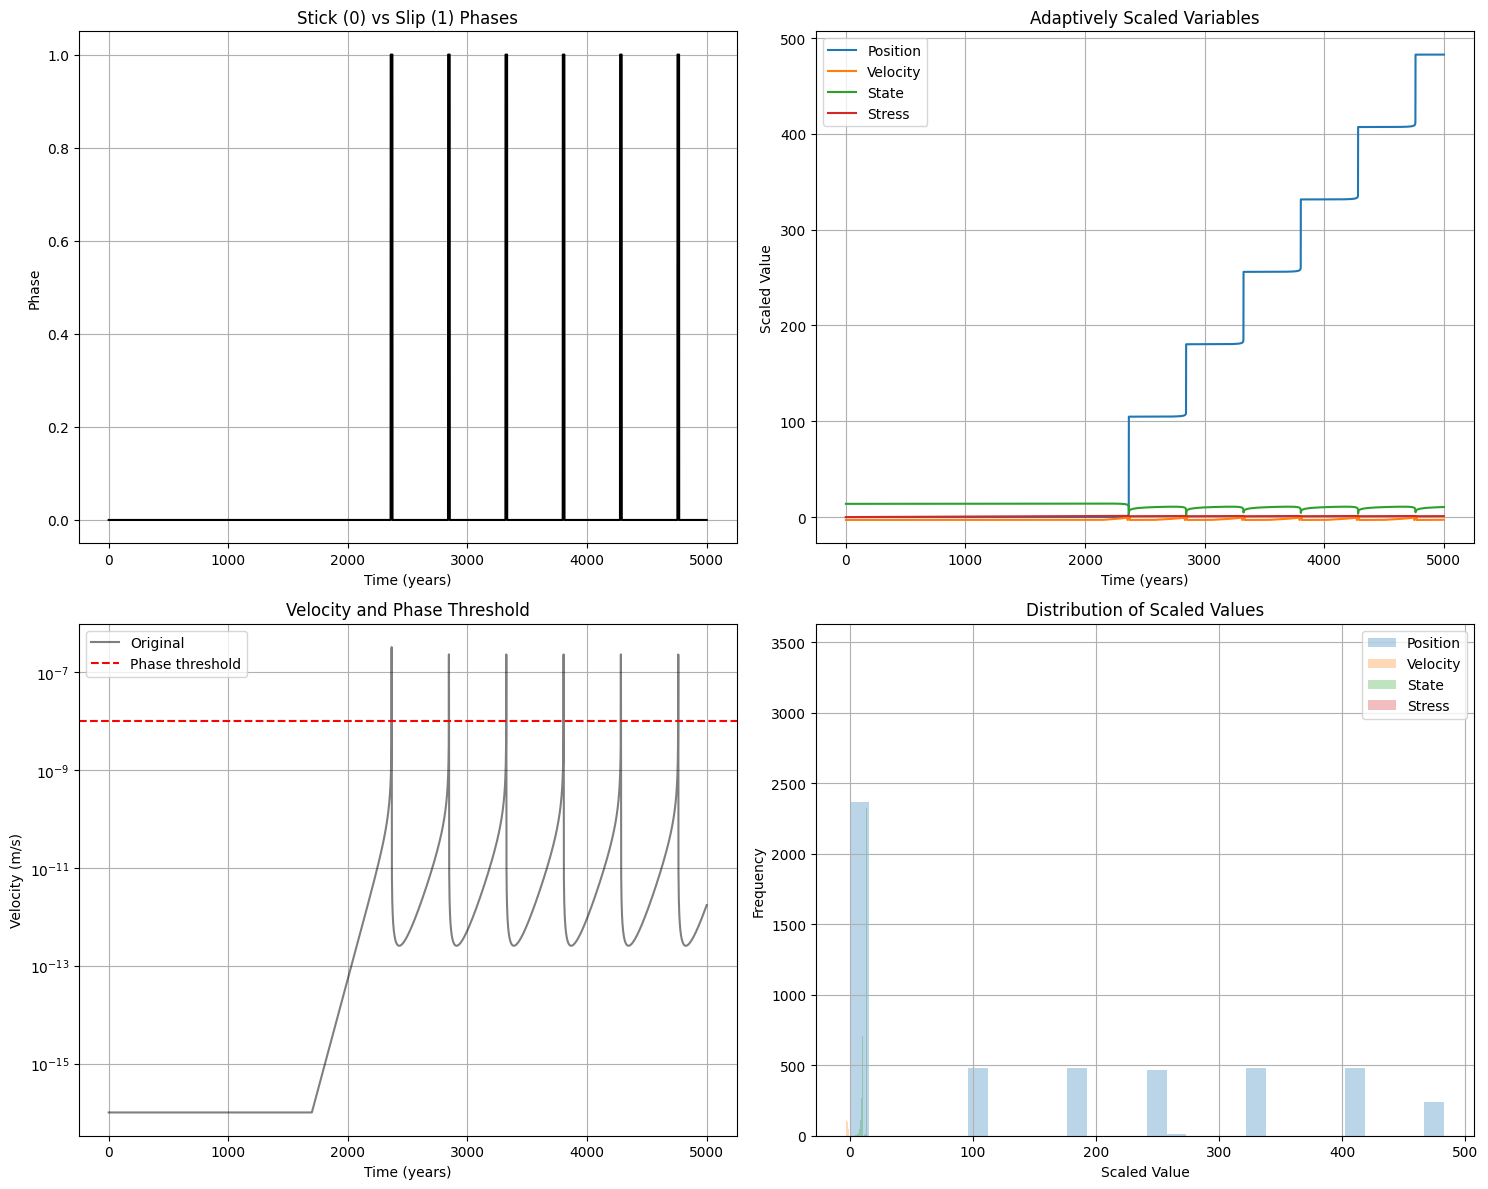


Applying SINDy with adaptively scaled data...
Using time step: 31536000.0
Model fitted successfully!

Discovered equations with adaptive scaling:
(x)' = 0.000
(v)' = 0.000
(state)' = 0.000
(tau)' = 0.000


/Users/gaoxinyue/anaconda3/envs/phi-sindy-env/lib/python3.8/site-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (0.0001) and eliminated all coefficients
  warnings.warn(


In [1]:
# Approach 2: Specialized Scaling for Multi-Timescale Dynamics
import numpy as np
import pysindy as ps
from pysindy.optimizers import STLSQ
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Load your data
try:
    X = np.load('../data/block_slider_data.npy')
    t = np.load('../data/block_slider_time.npy')
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Data files not found. Check paths.")

# Define physical constants for reference
f0 = 0.6        # Baseline friction coefficient
a = 0.015       # Direct velocity strengthening
b = 0.02        # State-based weakening 
Dc = 0.2        # Critical distance
V0 = 1e-6       # Reference velocity
k = 500000      # Spring constant
Vp = 1e-9       # Plate velocity

# Extract variables
x_data = X[:, 0]       # Position
v_data = X[:, 1]       # Velocity (slip rate)
state_data = X[:, 2]   # State variable
tau_data = X[:, 3]     # Shear stress

# Convert time to years for easier interpretation
secs_per_year = 365 * 24 * 60 * 60
t_years = t / secs_per_year

# Smooth the velocity data
window_size = 21
poly_order = 2
v_smooth = savgol_filter(v_data, window_length=window_size, polyorder=poly_order)

# Create a copy with smoothed velocity
X_smooth = X.copy()
X_smooth[:, 1] = np.maximum(v_smooth, 1e-12)  # Ensure positive velocity

# Define a specialized adaptive scaling function for earthquake dynamics
def adaptive_scaling(X, v_threshold=1e-8):
    """
    Adaptive scaling that treats stick and slip phases differently.
    
    Parameters:
    -----------
    X : array
        The data array with columns [x, v, state, tau]
    v_threshold : float
        Threshold to separate stick from slip phases
    
    Returns:
    --------
    X_scaled : array
        Scaled data
    phases : array
        Array indicating stick or slip phase for each point
    """
    X_scaled = np.zeros_like(X)
    
    # Identify stick and slip phases based on velocity
    v = X[:, 1]
    stick_mask = v < v_threshold
    slip_mask = v >= v_threshold
    
    # Store phase information
    phases = np.empty(len(v), dtype=object)
    phases[stick_mask] = 'stick'
    phases[slip_mask] = 'slip'
    
    print(f"Stick phase: {np.sum(stick_mask)} points")
    print(f"Slip phase: {np.sum(slip_mask)} points")
    
    # Apply specialized scaling to each variable
    for i in range(X.shape[1]):
        if i == 1:  # Velocity needs special treatment due to large range
            # For stick phase, scale relative to loading rate
            if np.any(stick_mask):
                X_scaled[stick_mask, i] = np.log10(X[stick_mask, i] / Vp)
            
            # For slip phase, scale relative to reference velocity
            if np.any(slip_mask):
                X_scaled[slip_mask, i] = np.log10(X[slip_mask, i] / V0)
        
        elif i == 2:  # State variable - preserve relative to steady state
            X_scaled[:, i] = (X[:, i] - f0) / b
        
        elif i == 3:  # Stress - scaled relative to strength
            X_scaled[:, i] = X[:, i] / (sigma_n * f0)
        
        else:  # Position - relative to critical displacement
            X_scaled[:, i] = X[:, i] / Dc
            
    return X_scaled, phases

# Apply the adaptive scaling
sigma_n = 50e6  # Normal stress
X_adaptive, phases = adaptive_scaling(X_smooth)

# Visualize the adaptively scaled data
plt.figure(figsize=(15, 12))

# Plot the phases
plt.subplot(221)
phase_numeric = np.zeros_like(t_years)
phase_numeric[phases == 'slip'] = 1
plt.plot(t_years, phase_numeric, 'k-')
plt.xlabel('Time (years)')
plt.ylabel('Phase')
plt.title('Stick (0) vs Slip (1) Phases')
plt.grid(True)

# Plot the scaled variables
plt.subplot(222)
for i, var_name in enumerate(['Position', 'Velocity', 'State', 'Stress']):
    plt.plot(t_years, X_adaptive[:, i], label=var_name)
plt.xlabel('Time (years)')
plt.ylabel('Scaled Value')
plt.title('Adaptively Scaled Variables')
plt.legend()
plt.grid(True)

# Plot scaled velocity to verify
plt.subplot(223)
plt.semilogy(t_years, v_data, 'k-', alpha=0.5, label='Original')
plt.axhline(y=1e-8, color='r', linestyle='--', label='Phase threshold')
plt.xlabel('Time (years)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity and Phase Threshold')
plt.legend()
plt.grid(True)

# Plot histogram of scaled values
plt.subplot(224)
for i, var_name in enumerate(['Position', 'Velocity', 'State', 'Stress']):
    plt.hist(X_adaptive[:, i], bins=30, alpha=0.3, label=var_name)
plt.xlabel('Scaled Value')
plt.ylabel('Frequency')
plt.title('Distribution of Scaled Values')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('../figures/adaptive_scaling.png')
plt.show()

# Try SINDy with the adaptively scaled data
print("\nApplying SINDy with adaptively scaled data...")

# Use a polynomial library
poly_lib = ps.PolynomialLibrary(degree=1)

# Try with a very low threshold
optimizer = STLSQ(threshold=1e-4)
model = ps.SINDy(
    optimizer=optimizer,
    feature_library=poly_lib,
    feature_names=["x", "v", "state", "tau"]
)

# Compute time step for derivatives
dt = np.median(np.diff(t))
print(f"Using time step: {dt}")

# Fit the model
try:
    model.fit(X_adaptive, t=dt)
    print("Model fitted successfully!")
    
    # Print the discovered equations
    print("\nDiscovered equations with adaptive scaling:")
    model.print()
    
except Exception as e:
    print(f"Error fitting model: {e}")
    print("Let's try a different approach.")